## Hybric RHC + Adam Neural Net Example

In [9]:
# Install pyperch if needed
!pip install pyperch

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

from pyperch.optim.rhc import RHC

# Set seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Generate synthetic data
X, y = make_classification(n_samples=1000, n_features=12, n_informative=10, random_state=seed)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed)

# Define the model with two hidden layers
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(12, 32)
        self.hidden2 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 2)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        return self.output(x)

model = MLP()
criterion = nn.CrossEntropyLoss()

# Separate parameter groups for optimizers
rhc_params = list(model.hidden1.parameters())  # RHC on first hidden layer
adam_params = list(model.hidden2.parameters()) + list(model.output.parameters())  # Adam on rest

# Instantiate optimizers
rhc_opt = RHC(rhc_params, step_size=0.05, max_no_improve=3, n_restarts=3, random_state=seed)
adam_opt = torch.optim.Adam(adam_params, lr=1e-3)

# Training loop
epochs = 50
train_losses = []
val_losses = []

for epoch in range(epochs):
    def rhc_closure():
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        return loss.item()  # Do not call backward()

    # Step RHC first (derivative-free)
    rhc_loss = rhc_opt.step(rhc_closure)

    # Then run Adam optimizer (gradient-based)
    model.train()
    adam_opt.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    adam_opt.step()

    # Evaluate validation loss
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val).item()

    train_losses.append(loss.item())  # use final loss after Adam step
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}")



Epoch 1/50, Train Loss: 0.3426, Val Loss: 0.6915
Epoch 2/50, Train Loss: 0.3426, Val Loss: 0.6886
Epoch 3/50, Train Loss: 0.3426, Val Loss: 0.6851
Epoch 4/50, Train Loss: 0.3426, Val Loss: 0.6856
Epoch 5/50, Train Loss: 0.3426, Val Loss: 0.6870
Epoch 6/50, Train Loss: 0.3426, Val Loss: 0.6866
Epoch 7/50, Train Loss: 0.3426, Val Loss: 0.6859
Epoch 8/50, Train Loss: 0.3426, Val Loss: 0.6856
Epoch 9/50, Train Loss: 0.3426, Val Loss: 0.6800
Epoch 10/50, Train Loss: 0.3426, Val Loss: 0.6796
Epoch 11/50, Train Loss: 0.3426, Val Loss: 0.6783
Epoch 12/50, Train Loss: 0.3426, Val Loss: 0.6707
Epoch 13/50, Train Loss: 0.3426, Val Loss: 0.6686
Epoch 14/50, Train Loss: 0.3426, Val Loss: 0.6616
Epoch 15/50, Train Loss: 0.3426, Val Loss: 0.6486
Epoch 16/50, Train Loss: 0.3426, Val Loss: 0.6522
Epoch 17/50, Train Loss: 0.3426, Val Loss: 0.6462
Epoch 18/50, Train Loss: 0.3426, Val Loss: 0.6461
Epoch 19/50, Train Loss: 0.3426, Val Loss: 0.6400
Epoch 20/50, Train Loss: 0.3426, Val Loss: 0.6320
Epoch 21/

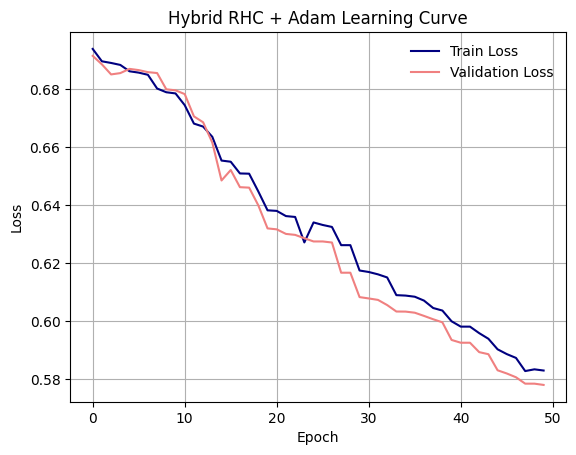

In [10]:
# Plot learning curves
plt.plot(train_losses, label='Train Loss', color='navy')
plt.plot(val_losses, label='Validation Loss', color='lightcoral')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Hybrid RHC + Adam Learning Curve")
plt.grid(visible=True)
plt.legend(frameon=False)
plt.show()